In [ ]:
# MET CS 767 - Machine Learning - Final Project
# Prasad Kothpalli
# Stock Price Prediction Problem Using XGBoost  Method
# Loading and Handling Data into pandas using Libraries

In [1]:
# This is XGBoost  Regression Model for Stock Price Prediction

In [2]:
import os
import time
import unicodedata
import numpy as np
import pandas as pd
import sklearn
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
#import fix_yahoo_finance
%matplotlib inline

C:\Users\prasadvk\AppData\Local\Continuum\anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# import Yahoo finance library 

In [3]:
from pandas_datareader import data as pdr #extract data from internet sources into pandas data frame
import yfinance as yf

yf.pdr_override()
start_date = "2019-02-13"
end_date = "2020-03-20"
stocks = 'NFLX'
data = pdr.get_data_yahoo(stocks, start = start_date, end = end_date )
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-02-13,357.299988,359.600006,350.279999,351.769989,351.769989,10559100
2019-02-14,351.750000,360.450012,348.329987,359.070007,359.070007,9295300
2019-02-15,358.470001,364.399994,355.500000,356.869995,356.869995,9230000
2019-02-19,355.799988,365.000000,355.320007,361.920013,361.920013,7396600
2019-02-20,364.850006,366.709991,356.700012,359.910004,359.910004,8110700
...,...,...,...,...,...,...
2020-03-13,330.510010,336.420013,307.390015,336.299988,336.299988,9458200
2020-03-16,306.630005,334.350006,294.750000,298.839996,298.839996,10559900
2020-03-17,306.190002,322.899994,290.250000,319.750000,319.750000,10013900


In [ ]:
# Build prepare data object  to build data set with several indicators like CCI, EWM etc.. 20 indicators
# are added to the dataset

In [4]:
class Prepare_data(object):
    def __init__(self):
        self.file_path = 'NFLX.csv'
        #self.data = pd.read_csv(self.file_path, index_col='Date')
        self.data = data
        self.data = self.data.replace('null',np.nan).fillna(0).astype('float')
        self.preprocessed_data = None
        
        days = 20
        self.data = self.CCI(self.data, days)
        
        days = 14
        self.data = self.EVM(self.data, days)

        days_list = [10,50,100,200]
        for days in days_list:
            self.data = self.SMA(self.data,days)
            self.data = self.EWMA(self.data,days)
       
        days = 5
        self.data = self.ROC(self.data,days)

        days = 50
        self.data = self.bbands(self.data, days)

        days = 1
        self.data = self.ForceIndex(self.data,days)
    
        self.preprocessed_data = self.rescale(self.data)

    def CCI(self, data, days):
        TP = (data['High'] + data['Low'] + data['Close']) / 3
        #CCI = pd.Series((TP - pd.rolling_mean(TP, days)) / (0.015 * pd.rolling_std(TP, days)),
        CCI = pd.Series((TP - TP.rolling(days).mean()) / (0.015 * TP.rolling(days).std()),
        name = 'CCI')
        data = data.join(CCI)
        return data

    def EVM(self, data, days): 
        dm = ((data['High'] + data['Low'])/2) - ((data['High'].shift(1) + data['Low'].shift(1))/2)
        br = (data['Volume'] / 100000000) / ((data['High'] - data['Low']))
        EVM = dm / br 
        EVM_MA = pd.Series(EVM.rolling(days).mean(), name = 'EVM') 
        data = data.join(EVM_MA) 
        return data

    def SMA(self,data, days): 
        sma = pd.Series(data['Close'].rolling(days).mean(), name = 'SMA_' + str(days))
        data = data.join(sma) 
        return data

    def EWMA(self, data, days):
        ema = pd.Series(data['Close'].ewm(span = days, min_periods = days - 1).mean(), 
        name = 'EWMA_' + str(days))
        data = data.join(ema) 
        return data

    def ROC(self,data,days):
        N = data['Close'].diff(days)
        D = data['Close'].shift(days)
        roc = pd.Series(N/D,name='ROW')
        data = data.join(roc)
        return data 

    def bbands(self, data, days):
        MA = data.Close.rolling(window=days).mean()
        SD = data.Close.rolling(window=days).std()
        data['UpperBB'] = MA + (2 * SD) 
        data['LowerBB'] = MA - (2 * SD)
        return data

    def ForceIndex(self, data, days): 
        FI = pd.Series(data['Close'].diff(days) * data['Volume'], name = 'ForceIndex') 
        data = data.join(FI) 
        return data

    def rescale(self, data):
        data = data.dropna().astype('float')
        rescaled_data = sklearn.preprocessing.scale(data)
        data = pd.DataFrame(rescaled_data, columns=data.columns)
 
        return data

In [ ]:
# Main class method to train and predict XGBClassifier  datamodel 

In [5]:
class Main(object):

    def __init__(self):
        self.data = None
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        self.model = None

    def prepare_X_y(self, data):
        X = data.values
        ind = list(data.columns).index('Open')
       
        y = []
        for i in range(X.shape[0]-1):
            if (X[i+1,ind]-X[i,ind])>0:
                y.append(1)
            else:
                y.append(0)
        y = np.array(y)
        X = X[:-1]
        return X,y

    def split_train_test(self,X,y):
        split_ratio=0.67
        train_size = int(round(split_ratio * X.shape[0]))
        X_train = X[:train_size]
        y_train = y[:train_size]
        X_test = X[train_size:]
        y_test = y[train_size:]

        print(X_train.shape, y_train.shape)
        print(X_test.shape, y_test.shape)
        return X_train, X_test, y_train, y_test

    def class_balance(train):
        count_class_0, count_class_1 = train['target'].value_counts()
        train_class_0 = train[train['target'] == 0]
        train_class_1 = train[train['target'] == 1]

        if count_class_0>count_class_1:
            train_class_0_under = train_class_0.sample(count_class_1)
            train_sampled = pd.concat([train_class_0_under, train_class_1], axis=0)
        else:
            train_class_1_under = train_class_1.sample(count_class_0)
            train_sampled = pd.concat([train_class_0, train_class_1_under], axis=0)

        print(train_sampled['target'].value_counts())
        train_sampled['target'].value_counts().plot(kind='bar', title='Count (target)')
        plt.show()
        return train_sampled

    def train_model(self, X_train, y_train):
        model = xgb.XGBClassifier()
        model.fit(X_train, y_train)
        return model

    def predict(self, model, X_test, y_test):
        y_pred = model.predict(X_test)
        y_pred = [round(value) for value in y_pred]
        accuracy = accuracy_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred)) 
        
        print("Accuracy: %.2f%%" % (accuracy * 100.0))
        print("RMSE: %.2f%%" % (rmse))
     
    def plot_feature_imp(self, data, model):
        imp_score = pd.DataFrame(model.feature_importances_, columns=['Importance Score'])
        features = pd.DataFrame(data.columns, columns=['Features'])
        feature_imp = pd.concat([features,imp_score], axis=1)
        feature_imp = feature_imp.sort_values('Importance Score', ascending=False)
        sns.barplot(x=feature_imp['Importance Score'], y=feature_imp['Features'])
        plt.show()

In [6]:
# Prepare the dataset with Technical Indicators.
Prepare_data = Prepare_data()
data = Prepare_data.preprocessed_data

In [7]:
##  Plot results to show the indicators and predict results, their acciracy and RSME results

(52, 20) (52,)
(25, 20) (25,)
Accuracy: 64.00%
RMSE: 0.60%


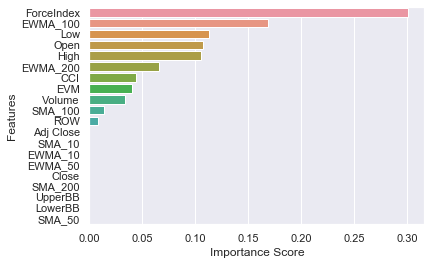

In [7]:
Main = Main()
Main.data = Prepare_data.preprocessed_data
X,y = Main.prepare_X_y(Main.data)
Main.X_train, Main.X_test, Main.y_train, Main.y_test = Main.split_train_test(X,y)
Main.model = Main.train_model(Main.X_train, Main.y_train)
Main.predict(Main.model, Main.X_test, Main.y_test)
Main.plot_feature_imp(Main.data, Main.model)

In [ ]:
# FB     74.11
# TTM    60.72
